In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('TSLA.csv', date_parser='Date')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [6]:
data.shape

(2416, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


In [8]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<AxesSubplot:xlabel='Date'>

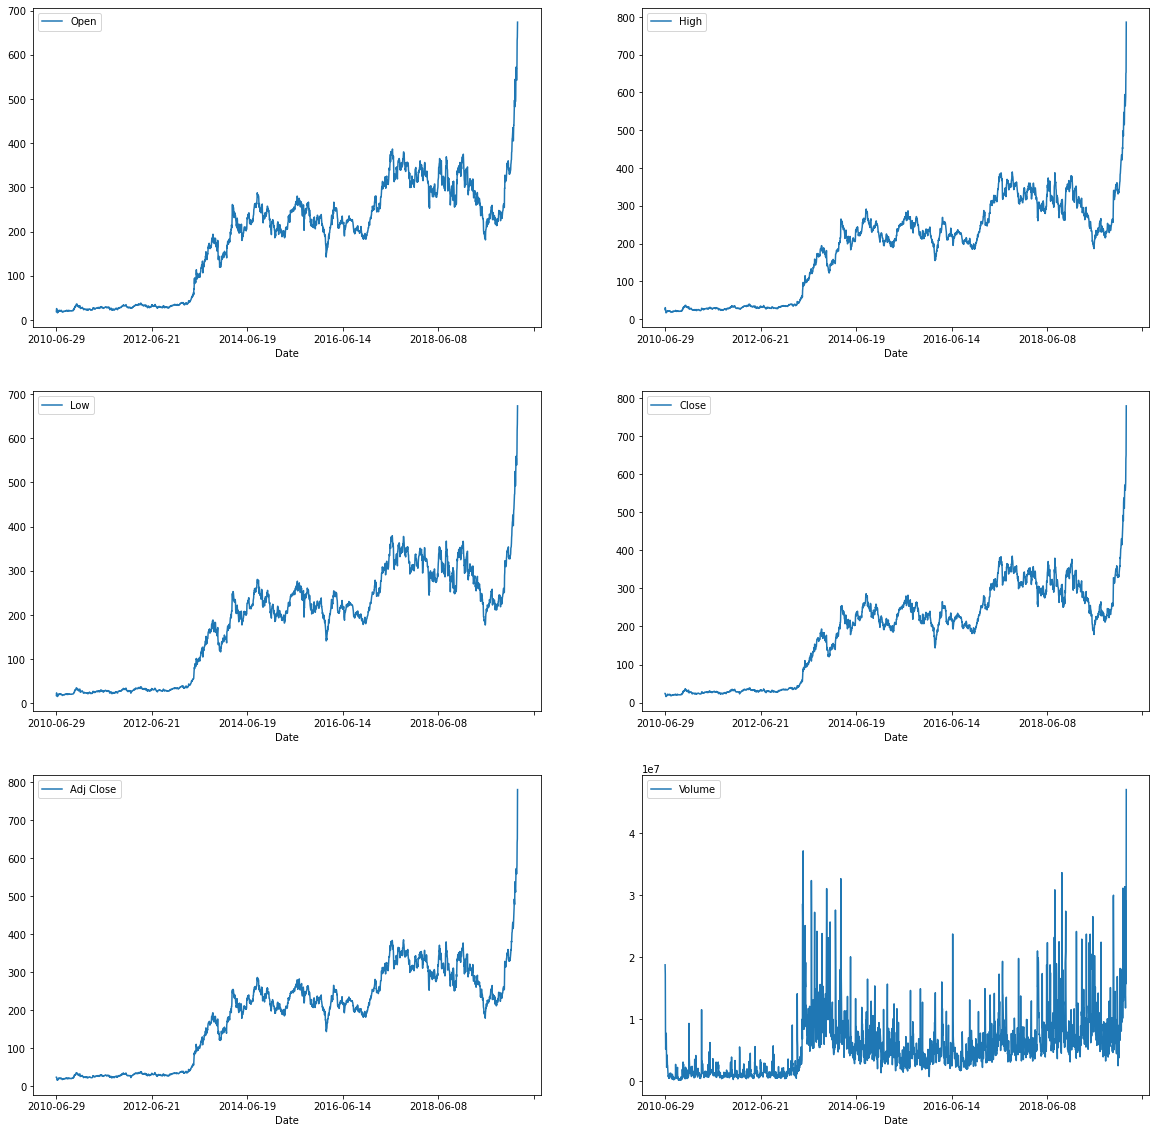

In [9]:
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(20,20))
data.plot(x='Date',y='Open',ax=axes[0,0])
data.plot(x='Date',y='High',ax=axes[0,1])
data.plot(x='Date',y='Low',ax=axes[1,0])
data.plot(x='Date',y='Close',ax=axes[1,1])
data.plot(x='Date',y='Adj Close',ax=axes[2,0])
data.plot(x='Date',y='Volume',ax=axes[2,1])

In [10]:
closing_price = data['Close']

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_closing_price = scaler.fit_transform(closing_price.values.reshape(-1, 1))

In [12]:
train_len=int(np.ceil(len(scaled_closing_price)*0.8))
train_data=scaled_closing_price[0:train_len,:]

In [13]:
train_x,train_y=[],[]
for i in range(60,len(train_data)):
    train_x.append(train_data[i-60:i,0])
    train_y.append(train_data[i,0])

In [14]:
train_x,train_y=np.array(train_x),np.array(train_y)
train_x=np.reshape(train_x,(train_x.shape[0],train_x.shape[1],1))

In [15]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(train_x.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [16]:
model.compile(loss='mse', optimizer='adam')

In [17]:
model.fit(train_x,train_y,batch_size=1,epochs=2)

Epoch 1/2
1873/1873 [==============================] - 67s 33ms/step - loss: 4.4894e-04
Epoch 2/2
1873/1873 [==============================] - 62s 33ms/step - loss: 2.5505e-04


In [18]:
test_data=scaled_closing_price[train_len-60:,:]

In [19]:
test_x=[]
test_y=data[train_len:]

In [20]:
for i in range(60,len(test_data)):
    test_x.append(test_data[i-60:i,0])

In [21]:
test_x=np.array(test_x)
test_x=np.reshape(test_x,(test_x.shape[0],test_x.shape[1],1))

In [22]:
predictions = model.predict(test_x)
predictions=scaler.inverse_transform(predictions)

16/16 [==============================] - 2s 24ms/step


In [23]:
train=data[:train_len]
valid=data[train_len:]
valid['Predictions']=predictions

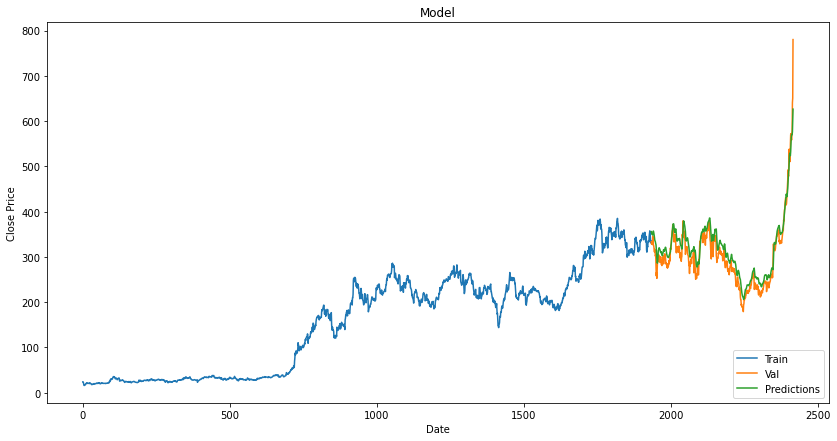

In [24]:
plt.figure(figsize=(14,7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

In [25]:
future_x=test_data[-60:]
future_x=np.array(future_x)
future_x=np.reshape(future_x,(1,future_x.shape[0],1))

In [26]:
future_predictions=[]
n=40
for _ in range(n):
    future_prediction=model.predict(future_x)
    future_predictions.append(future_prediction)
    future_x=np.reshape(future_x,(1,future_x.shape[1],1))
    future_x=np.append(future_x[:,1:,:],future_prediction.reshape(1,1,1),axis=1)

1/1 [==============================] - 0s 40ms/step


In [27]:
future_predictions=np.array(future_predictions)
future_predictions=scaler.inverse_transform(future_predictions.reshape(-1,1))